<a href="https://colab.research.google.com/github/juacastanori/PDI/blob/main/Proyecto/PDI_Comparacion_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Proyecto: PDI
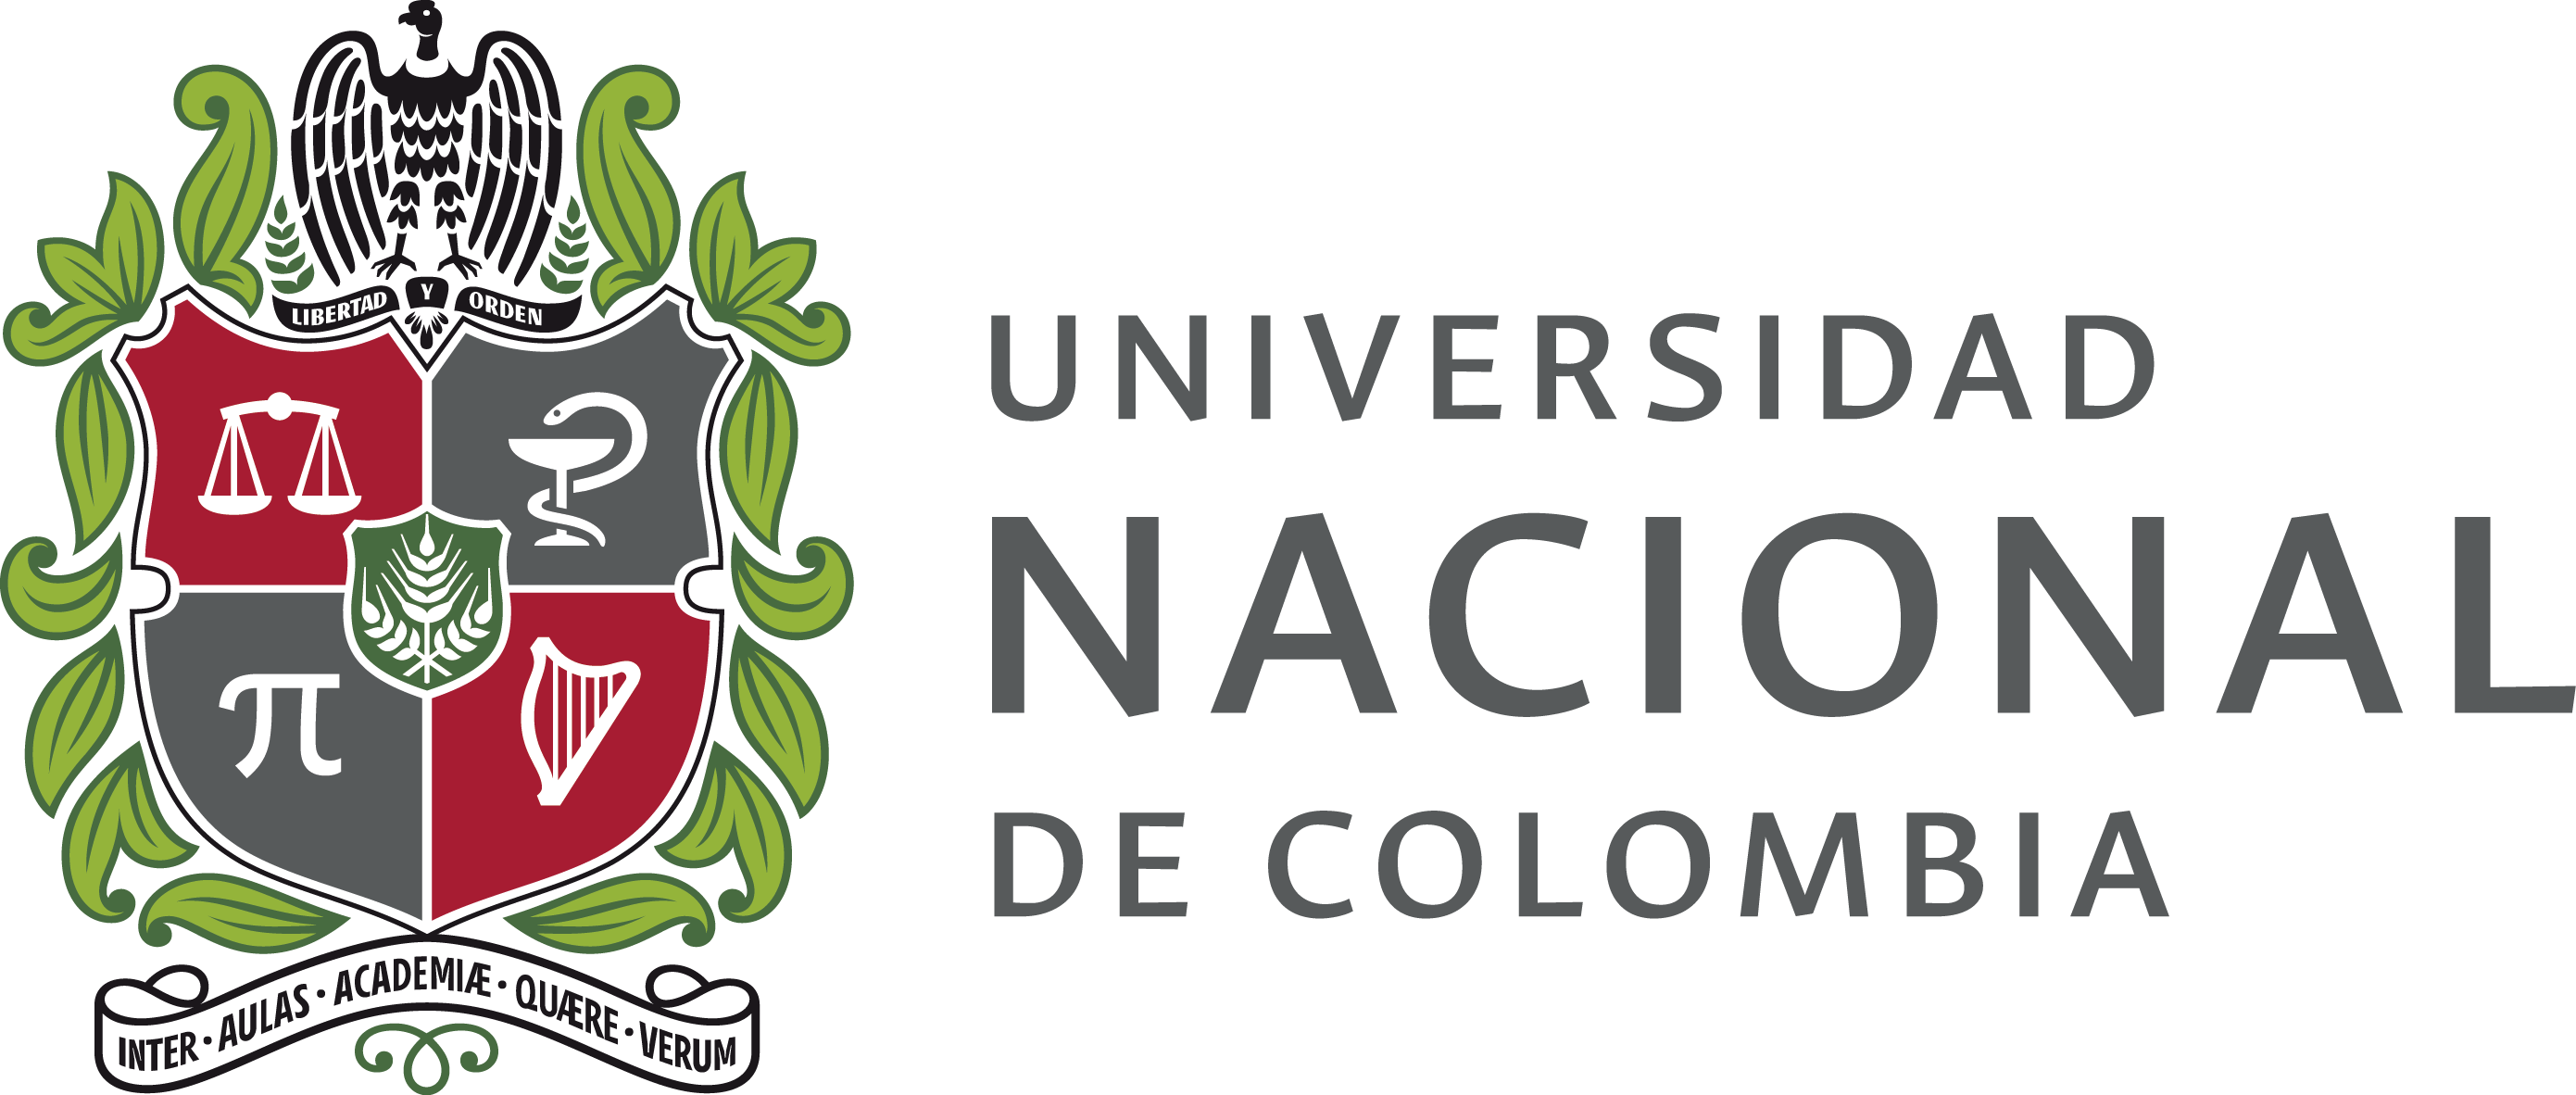
### **Universidad Nacional de Colombia sede Manizales**
#### Facultad de ingeniería y arquitectura
#### Departamento de ingeniería eléctrica, electrónica y computación
#### *Procesamiento digital de imágenes*

#### Profesor: Lucas Iturriago

#Hecho por:

## Juan Jerónimo Castaño Rivera
## Campos Herney Tulcan Cuasapud

## Comparación cualitativa (.pt vs TorchScript) — Notebook listo para Google Colab

In [ ]:
# 0) Instalar dependencias
!pip install -q ultralytics roboflow torch torchvision pillow matplotlib scikit-learn

!pip install --quiet gdown




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 41.0 MB/s eta 0:00:00


In [ ]:
# 1) Imports
import os, random, time, sys
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from shutil import copyfile
from IPython.display import display, Markdown
import gdown
print("Imports listos. torch:", torch.__version__, " CUDA disponible:", torch.cuda.is_available())

Imports listos. torch: 2.9.0+cu126  CUDA disponible: False


In [ ]:
# 2) Descargar dataset desde Roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="TBQT6PfDPRkkllrKI7UU")
project = rf.workspace("procesamientoimagenes").project("green_machinev2-nxegl-fzy6k")
version = project.version(1)
dataset = version.download("folder")
dataset_dir = dataset.location
print("Dataset descargado en:", dataset_dir)

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Green_MachineV2-1 in folder:: 100%|██████████| 3289/3289 [00:01<00:00, 2499.86it/s]

Dataset descargado en: /content/Green_MachineV2-1


In [ ]:
# Forzar ruta esperada (Roboflow típicamente usa /content/Green_MachineV2-1)
expected_test = "/content/Green_MachineV2-1/test"
if not os.path.isdir(expected_test):
    # buscar carpeta test dentro de dataset_dir
    found = None
    for root, dirs, files in os.walk(dataset_dir):
        if os.path.basename(root).lower() == 'test':
            found = root
            break
    if found:
        expected_test = found
        print("Usando carpeta test encontrada en:", expected_test)
    else:
        print("No se encontró carpeta test en la descarga. Revisa dataset_dir:", dataset_dir)
print("RUTA TEST FINAL ->", expected_test)

RUTA TEST FINAL -> /content/Green_MachineV2-1/test


In [ ]:
# Descargar modelos desde un enlace de Drive

model_pt= "1BCH7WG9CEoEA8P0HWXPxErRyIRSADw1F"
model_ts= "1epH-Xd8A7RZfdXZN858DEUELtANaukvS"

model_pt_path= "best.pt"
model_ts_path= "best.torchscript"

gdown.download(f"https://drive.google.com/uc?id={model_pt}", model_pt_path, quiet=False)
gdown.download(f"https://drive.google.com/uc?id={model_ts}", model_ts_path, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1BCH7WG9CEoEA8P0HWXPxErRyIRSADw1F
To: /content/best.pt
100%|██████████| 10.3M/10.3M [00:00<00:00, 50.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1epH-Xd8A7RZfdXZN858DEUELtANaukvS
To: /content/best.torchscript
100%|██████████| 20.5M/20.5M [00:00<00:00, 35.9MB/s]


'best.torchscript'

In [ ]:
# 4) Cargar modelos (safe globals para .pt) y medir tiempos de carga
from ultralytics import YOLO
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Usando dispositivo:", DEVICE)

ul_model = None
ts_model = None

# Función util: tamaño en MB
def filesize_mb(path):
    try:
        return os.path.getsize(path) / (1024*1024)
    except Exception:
        return None

# Intentar cargar .pt (medir tiempo)
pt_load_time = None
if model_pt_path is not None:
    t0 = time.perf_counter()
    try:
        # intentar permitir la clase si PyTorch lo requiere
        try:
            from ultralytics.nn.tasks import ClassificationModel
            if hasattr(torch.serialization, "add_safe_globals"):
                try:
                    torch.serialization.add_safe_globals([ClassificationModel])
                    print("ClassificationModel añadida a safe globals.")
                except Exception as e:
                    print("add_safe_globals falló:", e)
        except Exception as e:
            print("No se pudo preparar safe globals/importar ClassificationModel:", e)
        ul_model = YOLO(model_pt_path)
        try:
            ul_model.fuse()
        except Exception:
            pass
        pt_load_time = (time.perf_counter() - t0) * 1000.0  # ms
        print(f".pt cargado con YOLO() en {pt_load_time:.1f} ms. Clases:", getattr(ul_model,'names',None))
    except Exception as e:
        print("Error cargando .pt con YOLO():", e)
        ul_model = None
else:
    print("No se detectó .pt en el directorio actual.")

# Intentar cargar TorchScript (medir tiempo)
ts_load_time = None
if model_ts_path is not None:
    t0 = time.perf_counter()
    try:
        ts_model = torch.jit.load(model_ts_path, map_location=DEVICE)
        ts_model.eval()
        ts_load_time = (time.perf_counter() - t0) * 1000.0
        print(f"TorchScript cargado en {ts_load_time:.1f} ms desde {model_ts_path}")
    except Exception as e:
        print("Error cargando TorchScript:", e)
        ts_model = None
else:
    print("No se detectó archivo TorchScript en el directorio actual.")

if (ul_model is None) and (ts_model is None):
    raise RuntimeError("Ningún modelo cargado. Sube best.pt y/o best.torchscript.")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Usando dispositivo: cpu
ClassificationModel añadida a safe globals.
YOLOv8s-cls summary (fused): 30 layers, 5,089,291 parameters, 0 gradients, 12.5 GFLOPs
.pt cargado con YOLO() en 8587.8 ms. Clases: {0: 'Alo evera (SÃ¡bila)', 1: 'Calendula officinalis (Calendula)', 2: 'Chamaemelum nobile (Manzanilla)', 3: 'Dysphania ambrosioides (Paico)', 4: 'Eryngium foetidum (CimarrÃ³n)', 5: 'Erythroxylum coca (coca)', 6: 'Mentha spicata (Hierbabuena)', 7: 'Peumus boldus (Boldo)', 8: 'PlantasNoMedicinales', 9: 'Ruta graveolens (Ruda)', 10: 'Valeriana officinalis (Valeriana)'}
TorchScript cargado en 114.7 ms desde best.torchscript


In [ ]:
# 5) Preprocesamiento & funciones de inferencia
INPUT_SIZE = (640,640)

def preprocess_for_ts(img_path, input_size=INPUT_SIZE, device=DEVICE):
    img = Image.open(img_path).convert('RGB')
    img_resized = img.resize(input_size)
    arr = np.array(img_resized).astype('float32') / 255.0
    tensor = torch.from_numpy(arr).permute(2,0,1).unsqueeze(0).to(device)
    return tensor, np.array(img_resized)

def infer_ultralytics(model, image_path, imgsz=640):
    # devuelve (idx, probs_array_or_None, time_ms)
    t0 = time.perf_counter()
    res = model.predict(source=image_path, task='classify', imgsz=imgsz, device=0 if DEVICE=='cuda' else 'cpu', verbose=False)
    t1 = time.perf_counter()
    latency_ms = (t1-t0)*1000.0
    try:
        p = res[0].probs
        if hasattr(p, 'tensor'):
            probs = p.tensor.cpu().numpy().ravel()
        else:
            top_idx = int(p.top1)
            probs = np.zeros(len(model.names))
            probs[top_idx] = float(p.top1conf)
    except Exception:
        try:
            probs = np.array(res[0].probs)
        except Exception:
            probs = None
    if probs is None:
        try:
            idx = int(res[0].probs.top1)
            return idx, None, latency_ms
        except Exception:
            return None, None, latency_ms
    idx = int(np.argmax(probs))
    return idx, probs, latency_ms

def infer_torchscript(model, image_path, input_size=INPUT_SIZE):
    tensor, img_np = preprocess_for_ts(image_path, input_size=input_size, device=DEVICE)
    t0 = time.perf_counter()
    with torch.no_grad():
        out = model(tensor)
    t1 = time.perf_counter()
    latency_ms = (t1-t0)*1000.0
    probs = torch.softmax(out, dim=1)[0].cpu().numpy()
    idx = int(np.argmax(probs))
    return idx, probs, latency_ms

In [ ]:
# --------------------------
# 6) Lista de clases (usa tu cfg)
# --------------------------
cfg_names = [
    'Alo evera (SÃ¡bila)',
    'Calendula officinalis (Calendula)',
    'Chamaemelum nobile (Manzanilla)',
    'Dysphania ambrosioides (Paico)',
    'Eryngium foetidum (CimarrÃ³n)',
    'Erythroxylum coca (coca)',
    'Mentha spicata (Hierbabuena)',
    'Peumus boldus (Boldo)',
    'PlantasNoMedicinales',
    'Ruta graveolens (Ruda)',
    'Valeriana officinalis (Valeriana)'
]

In [ ]:
# 7) Mapear subcarpetas por clase dentro de test
import unicodedata
def normalize_str(s):
    s = str(s)
    s = unicodedata.normalize("NFKD", s)
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    s = s.lower().strip()
    s = s.replace(" ", "_")
    return s

test_root = expected_test
if not os.path.isdir(test_root):
    raise RuntimeError(f"No existe la carpeta de test: {test_root}")

available_dirs = [d for d in os.listdir(test_root) if os.path.isdir(os.path.join(test_root,d))]
norm_dirs = {normalize_str(d): d for d in available_dirs}

class_folder_map = {}
for cname in cfg_names:
    norm_c = normalize_str(cname)
    chosen = None
    if norm_c in norm_dirs:
        chosen = norm_dirs[norm_c]
    else:
        keywords = [w for w in norm_c.split("_") if len(w) > 2]
        for nd, real in norm_dirs.items():
            if any(kw in nd for kw in keywords):
                chosen = real
                break
    if chosen is None:
        first = norm_c.split("_")[0]
        for nd, real in norm_dirs.items():
            if first in nd:
                chosen = real
                break
    if chosen:
        class_folder_map[cname] = os.path.join(test_root, chosen)
    else:
        class_folder_map[cname] = None

print("Mapeo de clases -> carpetas detectadas:")
for c,n in class_folder_map.items():
    print("-", c, "->", n)

Mapeo de clases -> carpetas detectadas:
- Alo evera (SÃ¡bila) -> /content/Green_MachineV2-1/test/Alo evera (SÃ¡bila)
- Calendula officinalis (Calendula) -> /content/Green_MachineV2-1/test/Calendula officinalis (Calendula)
- Chamaemelum nobile (Manzanilla) -> /content/Green_MachineV2-1/test/Chamaemelum nobile (Manzanilla)
- Dysphania ambrosioides (Paico) -> /content/Green_MachineV2-1/test/Dysphania ambrosioides (Paico)
- Eryngium foetidum (CimarrÃ³n) -> /content/Green_MachineV2-1/test/Eryngium foetidum (CimarrÃ³n)
- Erythroxylum coca (coca) -> /content/Green_MachineV2-1/test/Erythroxylum coca (coca)
- Mentha spicata (Hierbabuena) -> /content/Green_MachineV2-1/test/Mentha spicata (Hierbabuena)
- Peumus boldus (Boldo) -> /content/Green_MachineV2-1/test/Peumus boldus (Boldo)
- PlantasNoMedicinales -> /content/Green_MachineV2-1/test/PlantasNoMedicinales
- Ruta graveolens (Ruda) -> /content/Green_MachineV2-1/test/Ruta graveolens (Ruda)
- Valeriana officinalis (Valeriana) -> /content/Green_Ma

In [ ]:
# 8) Selección balanceada K imágenes por clase
K = 1   # cambia a 2 o 3 para más muestras por clase
selected_images = []
selected_labels = []
for i, cname in enumerate(cfg_names):
    fpath = class_folder_map.get(cname)
    if fpath and os.path.isdir(fpath):
        imgs = [os.path.join(fpath, f) for f in os.listdir(fpath) if f.lower().endswith(('.jpg','.jpeg','.png'))]
        if len(imgs) > 0:
            chosen = random.sample(imgs, min(K, len(imgs)))
            selected_images.extend(chosen)
            selected_labels.extend([i]*len(chosen))
    else:
        print(f"No hay carpeta para la clase: {cname}")

if len(selected_images) == 0:
    raise RuntimeError("No se seleccionaron imágenes. Verifica las carpetas dentro de test/")

print(f"Seleccionadas {len(selected_images)} imágenes (K={K} por clase).")

Seleccionadas 11 imágenes (K=1 por clase).


In [ ]:
# 9) Medir latencias: warmup + repeats para estabilidad
def measure_model_latency(model_type, model_obj, image_paths, infer_fn, warmup=2, repeats=3):
    """Devuelve: avg_latency_ms_per_image, list_latencies_per_image"""
    latencies = []
    # warmup runs (use first image)
    if len(image_paths) == 0:
        return None, []
    img0 = image_paths[0]
    for _ in range(warmup):
        try:
            _ = infer_fn(model_obj, img0)
        except Exception:
            pass
    # measure per-image, repeats times
    for img in image_paths:
        total = 0.0
        successful = 0
        for r in range(repeats):
            try:
                _, _, tms = infer_fn(model_obj, img)
                total += tms
                successful += 1
            except Exception:
                pass
        avg = (total / successful) if successful>0 else None
        latencies.append(avg)
    # compute average over images (ignore None)
    valid = [x for x in latencies if x is not None]
    overall_avg = (sum(valid)/len(valid)) if len(valid)>0 else None
    return overall_avg, latencies

print("Midiendo latencias... esto puede tardar unos segundos por modelo dependiendo de N y repeats.")

pt_avg_latency, pt_latencies = (None, [])
ts_avg_latency, ts_latencies = (None, [])
if ul_model is not None:
    pt_avg_latency, pt_latencies = measure_model_latency('pt', ul_model, selected_images, infer_ultralytics, warmup=1, repeats=2)
    print(f"PT avg latency (ms/image): {pt_avg_latency:.2f}" if pt_avg_latency else "PT latency not available")
if ts_model is not None:
    ts_avg_latency, ts_latencies = measure_model_latency('ts', ts_model, selected_images, infer_torchscript, warmup=1, repeats=2)
    print(f"TS avg latency (ms/image): {ts_avg_latency:.2f}" if ts_avg_latency else "TS latency not available")

Midiendo latencias... esto puede tardar unos segundos por modelo dependiendo de N y repeats.
PT avg latency (ms/image): 315.52
TS avg latency (ms/image): 273.72


CSV guardado: qualitative_comparison.csv
Ejemplos distintos guardados en diff_examples/ (cantidad: 0)


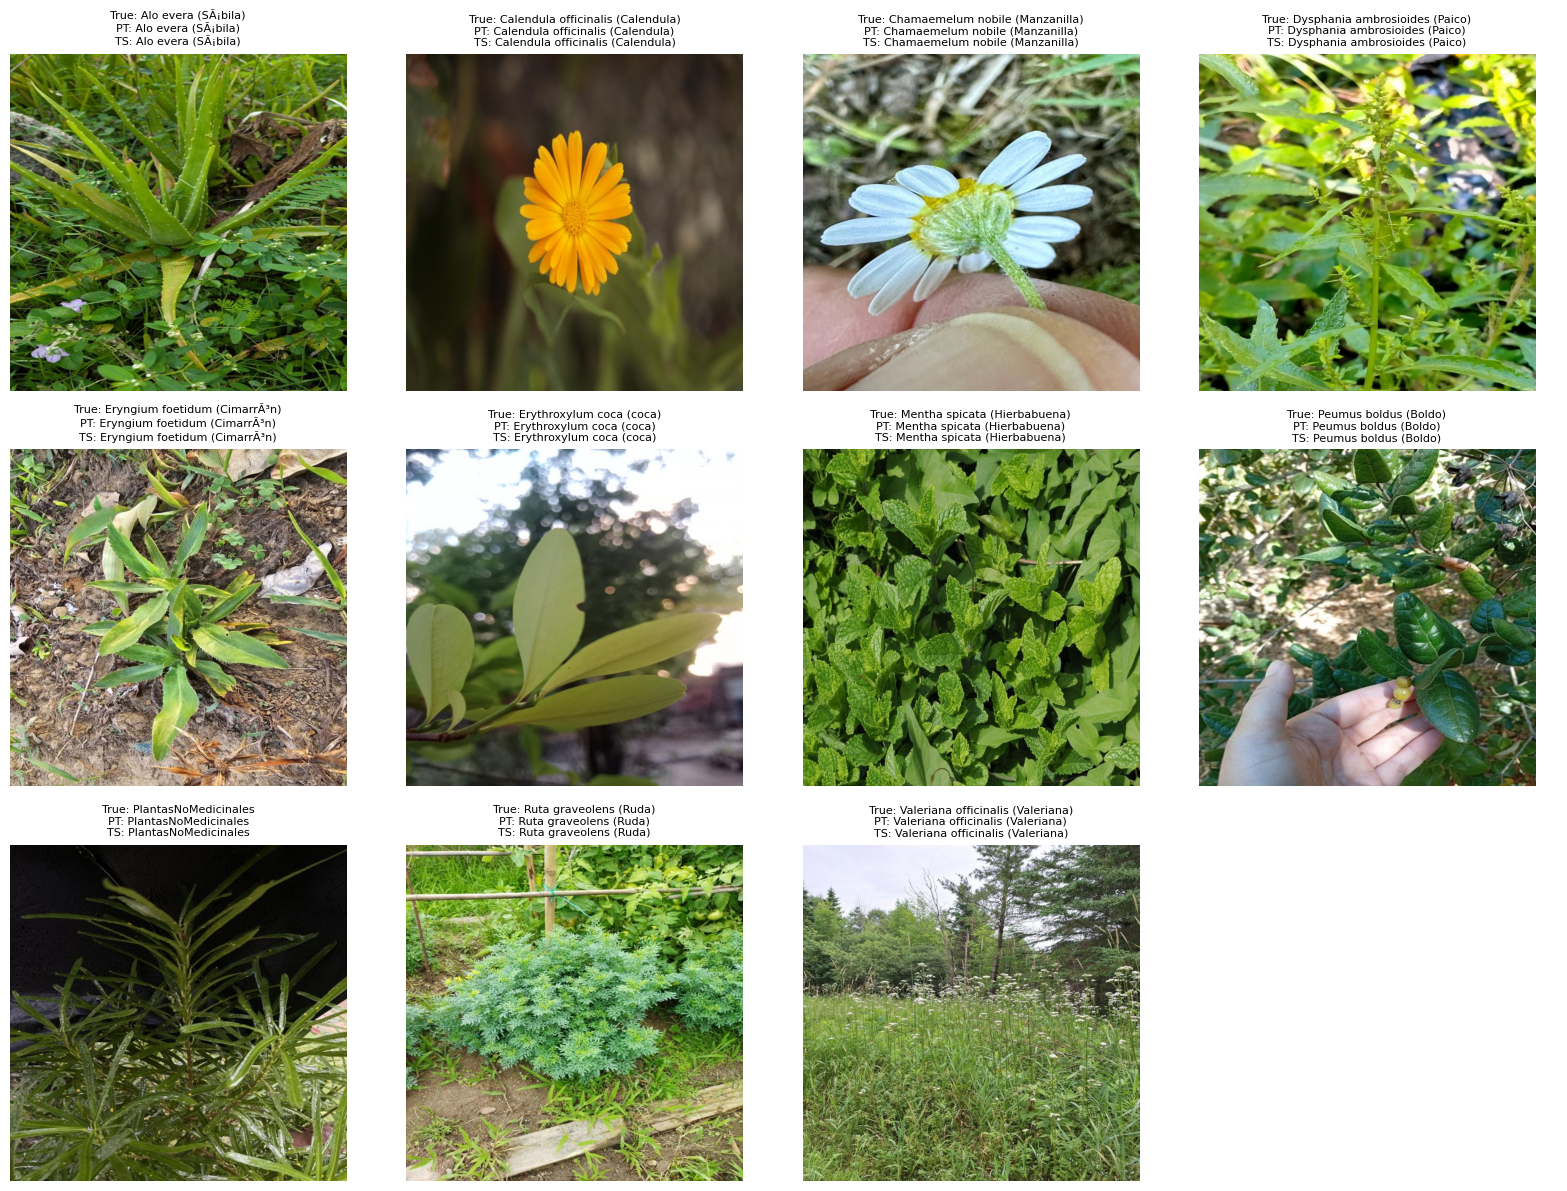

In [ ]:
# 10) Ejecutar inferencia una vez por imagen para resultados cualitativos y CSV (añadimos columnas de latency)
import csv
from math import ceil, sqrt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

rows_out = [['image','true_class','pt_pred','pt_conf','pt_latency_ms','ts_pred','ts_conf','ts_latency_ms']]

y_true = []
y_pred_pt = []
y_pred_ts = []

for img_path, true_idx in zip(selected_images, selected_labels):
    y_true.append(true_idx)
    # PT
    if ul_model is not None:
        try:
            idx_pt, probs_pt, t_pt = infer_ultralytics(ul_model, img_path)
        except Exception as e:
            print("Error infer PT:", e)
            idx_pt, probs_pt, t_pt = None, None, ''
    else:
        idx_pt, probs_pt, t_pt = None, None, ''
    # TS
    if ts_model is not None:
        try:
            idx_ts, probs_ts, t_ts = infer_torchscript(ts_model, img_path)
        except Exception as e:
            print("Error infer TS:", e)
            idx_ts, probs_ts, t_ts = None, None, ''
    else:
        idx_ts, probs_ts, t_ts = None, None, ''

    pt_name = (cfg_names[idx_pt] if (idx_pt is not None and isinstance(idx_pt,int) and 0<=idx_pt<len(cfg_names)) else '')
    ts_name = (cfg_names[idx_ts] if (idx_ts is not None and isinstance(idx_ts,int) and 0<=idx_ts<len(cfg_names)) else '')
    pt_conf = (float(probs_pt[idx_pt])*100) if (probs_pt is not None and idx_pt is not None and idx_pt < len(probs_pt)) else ''
    ts_conf = (float(probs_ts[idx_ts])*100) if (probs_ts is not None and idx_ts is not None and idx_ts < len(probs_ts)) else ''

    rows_out.append([img_path, cfg_names[true_idx], pt_name, pt_conf, t_pt, ts_name, ts_conf, t_ts])

    y_pred_pt.append(idx_pt if idx_pt is not None else -1)
    y_pred_ts.append(idx_ts if idx_ts is not None else -1)

# guardar CSV
csv_path = 'qualitative_comparison.csv'
with open(csv_path, 'w', newline='', encoding='utf-8') as f:
    w = csv.writer(f)
    w.writerows(rows_out)
print("CSV guardado:", csv_path)

# crear diff_examples
os.makedirs('diff_examples', exist_ok=True)
diff_count = 0
for img, pt, ts in zip(selected_images, y_pred_pt, y_pred_ts):
    if pt != ts:
        try:
            copyfile(img, os.path.join('diff_examples', os.path.basename(img)))
            diff_count += 1
        except Exception as e:
            print("No se pudo copiar", img, e)
print(f"Ejemplos distintos guardados en diff_examples/ (cantidad: {diff_count})")

# mostrar grid
cols = int(ceil(sqrt(len(selected_images))))
rows = int(ceil(len(selected_images)/cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
axes = axes.flatten()
for i, img_path in enumerate(selected_images):
    ax = axes[i]
    img = Image.open(img_path).convert('RGB')
    ax.imshow(img)
    true_name = cfg_names[selected_labels[i]]
    pt_idx = y_pred_pt[i]
    ts_idx = y_pred_ts[i]
    pt_name = cfg_names[pt_idx] if (pt_idx>=0 and pt_idx < len(cfg_names)) else '-'
    ts_name = cfg_names[ts_idx] if (ts_idx>=0 and ts_idx < len(cfg_names)) else '-'
    ax.set_title(f"True: {true_name}\nPT: {pt_name}\nTS: {ts_name}", fontsize=8)
    ax.axis('off')
for ax in axes[len(selected_images):]:
    ax.axis('off')
plt.tight_layout()
plt.show()

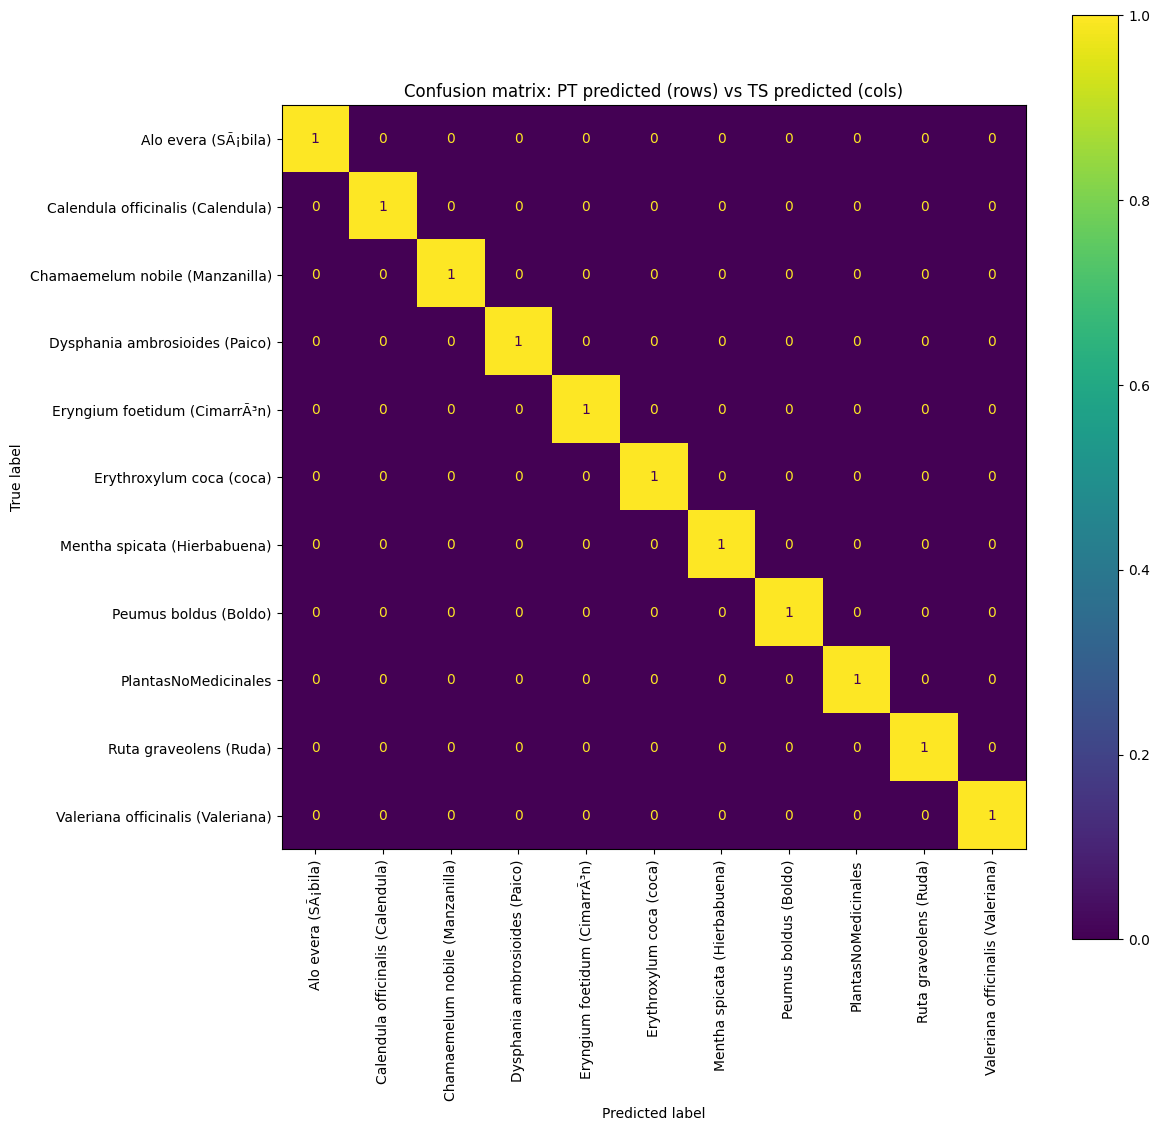

In [ ]:
# 11) Matriz de confusión PT vs TS (si ambos disponibles)
if (ul_model is not None) and (ts_model is not None):
    valid_idx = [i for i,(pt,ts) in enumerate(zip(y_pred_pt,y_pred_ts)) if pt is not None and ts is not None and pt>=0 and ts>=0]
    if len(valid_idx) > 0:
        y_pt = [y_pred_pt[i] for i in valid_idx]
        y_ts = [y_pred_ts[i] for i in valid_idx]
        cm = confusion_matrix(y_pt, y_ts, labels=list(range(len(cfg_names))))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cfg_names)
        fig2, ax2 = plt.subplots(figsize=(12,12))
        disp.plot(ax=ax2, xticks_rotation='vertical', colorbar=True)
        plt.title("Confusion matrix: PT predicted (rows) vs TS predicted (cols)")
        plt.show()
    else:
        print("No hay predicciones válidas para construir la matriz de confusión.")
else:
    print("Matriz de confusión requiere ambos modelos cargados (PT y TorchScript).")


In [ ]:
# 12) Comparación de tamaños y resumen de tiempos
print("\n=== RESUMEN DE TAMAÑOS Y TIEMPOS ===")
if model_pt_path is not None:
    print(f".pt file: {model_pt_path} -> {filesize_mb(model_pt_path):.2f} MB ; load_time_ms: {pt_load_time if pt_load_time else 'N/A'}")
if model_ts_path is not None:
    print(f".torchscript file: {model_ts_path} -> {filesize_mb(model_ts_path):.2f} MB ; load_time_ms: {ts_load_time if ts_load_time else 'N/A'}")
if pt_avg_latency:
    print(f".pt avg inference latency (ms/image) measured: {pt_avg_latency:.2f}")
if ts_avg_latency:
    print(f".torchscript avg inference latency (ms/image) measured: {ts_avg_latency:.2f}")


=== RESUMEN DE TAMAÑOS Y TIEMPOS ===
.pt file: best.pt -> 9.81 MB ; load_time_ms: 8587.840725000035
.torchscript file: best.torchscript -> 19.56 MB ; load_time_ms: 114.65809100002389
.pt avg inference latency (ms/image) measured: 315.52
.torchscript avg inference latency (ms/image) measured: 273.72


In [ ]:
# 13) Guardar resumen en un TXT
summary_path = 'model_comparison_summary.txt'
with open(summary_path, 'w', encoding='utf-8') as f:
    f.write("Model comparison summary\\n\\n")
    if model_pt_path is not None:
        f.write(f".pt file: {model_pt_path} -> {filesize_mb(model_pt_path):.2f} MB ; load_time_ms: {pt_load_time if pt_load_time else 'N/A'}\\n")
    if model_ts_path is not None:
        f.write(f".torchscript file: {model_ts_path} -> {filesize_mb(model_ts_path):.2f} MB ; load_time_ms: {ts_load_time if ts_load_time else 'N/A'}\\n")
    if pt_avg_latency:
        f.write(f".pt avg inference latency (ms/image): {pt_avg_latency:.2f}\\n")
    if ts_avg_latency:
        f.write(f".torchscript avg inference latency (ms/image): {ts_avg_latency:.2f}\\n")
    f.write(f"Selected images: {len(selected_images)} (K={K} per class)\\n")
print("Resumen guardado en", summary_path)


Resumen guardado en model_comparison_summary.txt
